---
title: "Lab 4 - Sparse vectors and Sentiment Analysis"
output-file: 04-sentiment_analysis.html
---

# Sparse Vectors: Text Representation for Sentiment Analysis

How do we turn text into numbers a model can use? This notebook walks through the pipeline from raw text to numeric feature vectors, with an emphasis on **sparse representations** — vectors where most entries are zero.

We build up several different representations of the same text:

| Approach | Output | Sparse? | Learns from data? |
|---|---|---|---|
| Count Vectorizer (Bag of Words) | Word counts | Yes | No (just counting) |
| TF-IDF Vectorizer | Weighted importance | Yes | No (statistical weighting) |
| VADER | Sentiment scores | No (dense, 4-dim) | No (rule-based dictionary) |
| Naive Bayes | Class probabilities | Dense internally | Yes |
| Logistic Regression + L1 | Learned weights | Yes (with L1) | Yes |

**Central question:** When we compress a sentence into a vector, what information do we keep, what do we lose, and how does the choice of representation affect a downstream task like sentiment classification?

In [ ]:
#| eval: false

import data401_nlp
from data401_nlp.helpers.spacy import ensure_spacy_model

def get_nlp():
    return ensure_spacy_model("en_core_web_sm")

In [ ]:
#| eval: false

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import issparse

import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

## The Representation Problem

Text is **symbolic** and **variable-length**: "great movie" has 2 words while "the ending was truly horrible and I want my money back" has 10. Machine learning models need **fixed-size numeric inputs**.

The standard solution: create a **vocabulary** of every unique word in the corpus, then represent each document as a vector with one dimension per vocabulary word. A corpus with 10,000 unique words produces 10,000-dimensional vectors.

But any single document uses only a tiny fraction of those words. Most entries are zero. That's a **sparse vector**.

> **Sparse vector**: A vector where most elements are zero. Only the non-zero entries need to be stored — a natural form of compression.

## A Toy Corpus

We'll work with a small labeled corpus — 10 movie reviews with binary sentiment labels. In practice you'd want thousands of documents, but a toy corpus lets us inspect every step.

In [ ]:
#| eval: false

corpus = [
    "I love this movie, it was great!",
    "terrible film, absolutely horrible",
    "the acting was excellent and moving",
    "I hated every minute of it",
    "a wonderful experience from start to finish",
    "boring and predictable, waste of time",
    "amazing performances by the entire cast",
    "not good, very disappointing",
    "brilliant story with heart",
    "awful, just awful",
]

labels = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])  # 1 = positive, 0 = negative

pd.DataFrame({
    "text": corpus,
    "sentiment": ["positive" if l else "negative" for l in labels]
})

,text,sentiment
0,"I love this movie, it was great!",positive
1,"terrible film, absolutely horrible",negative
2,the acting was excellent and moving,positive
3,I hated every minute of it,negative
4,a wonderful experience from start to finish,positive
5,"boring and predictable, waste of time",negative
6,amazing performances by the entire cast,positive
7,"not good, very disappointing",negative
8,brilliant story with heart,positive
9,"awful, just awful",negative


## Step 1: Tokenization

Before counting words, we need to decide what counts as a "word." **Tokenization** splits text into tokens. Using spaCy we can also:

- **Lemmatize** — reduce words to base forms ("running" → "run", "movies" → "movie")
- **Remove stop words** — discard high-frequency function words ("the", "is", "it")
- **Remove punctuation** — strip commas, periods, etc.

Each choice affects what information the final vector preserves. Lemmatization merges related forms into one dimension (compression). Stop word removal eliminates dimensions that don't help distinguish documents (noise reduction).

Scikit-learn, the library we'll use below for naive bayes and logistic regression also has a tokenization function. However, since we are learning to use spacy and the spacy pipeline, we will not use scikit-learn's tokenization or pipeline functionality.

In [ ]:
#| eval: false

# Just a reminder. If you were not using this helper function, you would use 
# nlp = spacy.load("en_core_web_sm")
# after ensuring you'd already downloaded this model


nlp = get_nlp()

✅ spaCy model 'en_core_web_sm' loaded successfully


In [ ]:
#| eval: false

def tokenize(text):
    """Tokenize, lemmatize, and filter stop words / punctuation using spaCy."""
    doc = nlp(text)
    return [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop
        and not token.is_punct
        and not token.is_space
    ]

In [ ]:
#| eval: false

# What does tokenization actually do?
example = "The acting was excellent and truly moving"

raw = example.split()
processed = tokenize(example)

print(f"Raw text:      '{example}'")
print(f"Split tokens:   {raw}  ({len(raw)} tokens)")
print(f"After spaCy:    {processed}  ({len(processed)} tokens)")
print(f"\nCompression: {len(raw)} tokens → {len(processed)} tokens")
print(f"Removed stop words and punctuation, lemmatized the rest.")

Raw text:      'The acting was excellent and truly moving'
Split tokens:   ['The', 'acting', 'was', 'excellent', 'and', 'truly', 'moving']  (7 tokens)
After spaCy:    ['acting', 'excellent', 'truly', 'move']  (4 tokens)

Compression: 7 tokens → 4 tokens
Removed stop words and punctuation, lemmatized the rest.


### One-Hot Encoding: The Simplest Sparse Vector

Before counting words across a whole document, it helps to see how we represent a **single word** as a vector.

**One-hot encoding** assigns each word in the vocabulary its own dimension. To represent a word, set its dimension to 1 and everything else to 0:

```
Vocabulary: [awful, boring, brilliant, cast, ..., wonderful]
"brilliant" →  [0,    0,       1,        0,   ...,    0     ]
"awful"     →  [1,    0,       0,        0,   ...,    0     ]
```

This is the **maximally sparse** vector — exactly one non-zero entry out of the entire vocabulary. With 30 vocabulary words, 29 of the 30 entries are zero.

The connection to Count Vectorization (next section) is direct: a document's count vector is the **sum of the one-hot vectors** for every token in that document. 

> **One-hot encoding** is widely used outside NLP as well. Whenever you have a categorical variable (color, country, part-of-speech tag), one-hot encoding converts it into a binary vector that models can consume. The key trade-off: the vector length equals the number of categories, which can get very large.

In [ ]:
#| eval: false

# Build vocabulary from our corpus (same words CountVectorizer will find)
all_tokens = sorted(set(tok for doc in corpus for tok in tokenize(doc)))

def one_hot(word, vocabulary):
    """One-hot vector: a single 1 at the word's position, zeros everywhere else."""
    vec = np.zeros(len(vocabulary), dtype=int)
    if word in vocabulary:
        vec[vocabulary.index(word)] = 1
    return vec

# One-hot vectors for individual words
print(f"Vocabulary: {len(all_tokens)} words\n")
for word in ["brilliant", "awful", "movie"]:
    idx = all_tokens.index(word)
    vec = one_hot(word, all_tokens)
    print(f'  "{word}"  → position {idx}, vector has {len(all_tokens)} dims, 1 non-zero')

# Sum of one-hots = count vector for a document
print(f"\n--- Summing one-hots for a document ---")
sentence = "awful, just awful"
tokens = tokenize(sentence)
print(f"Document: '{sentence}'")
print(f"Tokens:    {tokens}\n")

doc_vector = sum(one_hot(tok, all_tokens) for tok in tokens)
nonzero = {all_tokens[i]: int(doc_vector[i]) for i in np.where(doc_vector > 0)[0]}
print(f"Sum of one-hots: {nonzero}")
print(f"'awful' appears twice → its count is 2. This is exactly a count vector!")

Vocabulary: 30 words

  "brilliant"  → position 5, vector has 30 dims, 1 non-zero
  "awful"  → position 3, vector has 30 dims, 1 non-zero
  "movie"  → position 21, vector has 30 dims, 1 non-zero

--- Summing one-hots for a document ---
Document: 'awful, just awful'
Tokens:    ['awful', 'awful']

Sum of one-hots: {'awful': 2}
'awful' appears twice → its count is 2. This is exactly a count vector!


## Step 2: Count Vectorization (Bag of Words)

The simplest text → vector mapping. Build a vocabulary from the entire corpus (each unique token becomes a column), then represent each document by counting how many times each vocabulary word appears.

The result is a **document-term matrix**: rows = documents, columns = vocabulary words, values = counts.

This representation is called "bag of words" because it discards word order entirely — only frequency survives the compression.

In [ ]:
#| eval: false

count_vec = CountVectorizer(
    tokenizer=tokenize,
    token_pattern=None   # use our spacy tokenizer, not sklearn's regex
)
X_counts = count_vec.fit_transform(corpus)
vocab = count_vec.get_feature_names_out()

print(f"Documents:       {len(corpus)}")
print(f"Vocabulary size: {len(vocab)} unique tokens")
print(f"Matrix shape:    {X_counts.shape}  (documents × vocabulary)")
print(f"Storage type:    {type(X_counts).__name__} (scipy sparse matrix)")
print(f"\nVocabulary:\n  {list(vocab)}")

Documents:       10
Vocabulary size: 30 unique tokens
Matrix shape:    (10, 30)  (documents × vocabulary)
Storage type:    csr_matrix (scipy sparse matrix)

Vocabulary:
  ['absolutely', 'acting', 'amazing', 'awful', 'boring', 'brilliant', 'cast', 'disappointing', 'entire', 'excellent', 'experience', 'film', 'finish', 'good', 'great', 'hat', 'heart', 'horrible', 'love', 'minute', 'move', 'movie', 'performance', 'predictable', 'start', 'story', 'terrible', 'time', 'waste', 'wonderful']


In [ ]:
#| eval: false

count_vec.vocabulary_

{'love': 18,
 'movie': 21,
 'great': 14,
 'terrible': 26,
 'film': 11,
 'absolutely': 0,
 'horrible': 17,
 'acting': 1,
 'excellent': 9,
 'move': 20,
 'hat': 15,
 'minute': 19,
 'wonderful': 29,
 'experience': 10,
 'start': 24,
 'finish': 12,
 'boring': 4,
 'predictable': 23,
 'waste': 28,
 'time': 27,
 'amazing': 2,
 'performance': 22,
 'entire': 8,
 'cast': 6,
 'good': 13,
 'disappointing': 7,
 'brilliant': 5,
 'story': 25,
 'heart': 16,
 'awful': 3}

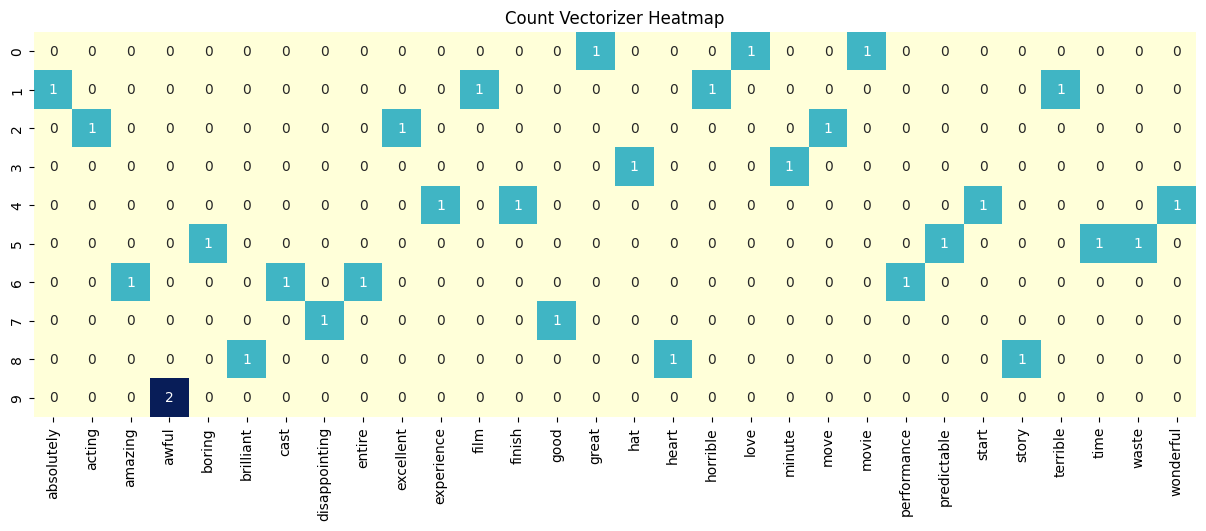

In [ ]:
#| eval: false

import seaborn as sns
import pandas as pd

# Convert to a DataFrame for easier labeling in Seaborn
df_counts = pd.DataFrame(X_counts.toarray(), columns=vocab)

plt.figure(figsize=(15, 5))
sns.heatmap(df_counts, annot=True, cbar=False, cmap="YlGnBu")
plt.title("Count Vectorizer Heatmap")
plt.show()

### Exercise 1
Why does document 9 have a '2' for 'awful'?

In [ ]:
q1_answer = ""

### How sparse is this matrix?

If we stored the full matrix densely, every document would need a slot for every vocabulary word — even words that don't appear. Let's measure the waste.

In [ ]:
#| eval: false

total_entries = X_counts.shape[0] * X_counts.shape[1]
nonzero = X_counts.nnz
zero = total_entries - nonzero

print(f"Total entries:    {total_entries}")
print(f"Non-zero entries: {nonzero}")
print(f"Zero entries:     {zero}")
print(f"Sparsity:         {zero / total_entries:.1%}")
print(f"\nDense storage:  {total_entries} values")
print(f"Sparse storage: ~{nonzero * 2} values (non-zero value + column index per entry)")
print(f"Compression:     ~{total_entries / (nonzero * 2):.1f}× smaller")
print(f"\nIn a real corpus with 50,000 words and 10,000 documents,")
print(f"sparsity would be >99% — sparse storage saves orders of magnitude.")

Total entries:    300
Non-zero entries: 30
Zero entries:     270
Sparsity:         90.0%

Dense storage:  300 values
Sparse storage: ~60 values (non-zero value + column index per entry)
Compression:     ~5.0× smaller

In a real corpus with 50,000 words and 10,000 documents,
sparsity would be >99% — sparse storage saves orders of magnitude.


In [ ]:
#| eval: false

# Under the hood: scipy's Compressed Sparse Row (CSR) format
# Instead of a 2D grid of mostly zeros, it stores three arrays:

print("CSR stores only what's needed:\n")
print(f"  data:    {X_counts.data}")
print(f"           ({len(X_counts.data)} non-zero values)\n")
print(f"  indices: {X_counts.indices}")
print(f"           (which column each value belongs to)\n")
print(f"  indptr:  {X_counts.indptr}")
print(f"           (where each row starts in the data array)")

CSR stores only what's needed:

  data:    [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2]
           (30 non-zero values)

  indices: [18 21 14 26 11  0 17  1  9 20 15 19 29 10 24 12  4 23 28 27  2 22  8  6
 13  7  5 25 16  3]
           (which column each value belongs to)

  indptr:  [ 0  3  7 10 12 16 20 24 26 29 30]
           (where each row starts in the data array)


To make sense of this, look at the index pointers i and i+1... for example, 0 and 3. This means document 1 uses the indices in positions 0,1,2 which are 18, 21, and 14. This means that document 0 has non-zero values at column 18, 21, and 14. You can see this visually in the document-term matrix.

Let's visualize this another way!

In [ ]:
#| eval: false

def show_sparse_vector(vector, feature_names, label=""):
    """Display only the non-zero entries of a sparse or dense vector."""
    if issparse(vector):
        vector = vector.toarray().flatten()
    else:
        vector = np.asarray(vector).flatten()

    nonzero_idx = np.where(np.abs(vector) > 1e-6)[0]
    entries = {feature_names[i]: round(float(vector[i]), 4) for i in nonzero_idx}
    n_dims = len(feature_names)
    n_nz = len(entries)

    if label:
        print(f"  {label}")
    print(f"  Dimensions: {n_dims} total, {n_nz} non-zero ({n_nz}/{n_dims})")
    print(f"  Non-zero:   {entries}")
    return entries

In [ ]:
#| eval: false

# Inspect one document's representation
doc_idx = 0
print(f"Document: '{corpus[doc_idx]}'")
print(f"Tokens:    {tokenize(corpus[doc_idx])}")
print()
show_sparse_vector(X_counts[doc_idx], vocab, label="Count vector:");

Document: 'I love this movie, it was great!'
Tokens:    ['love', 'movie', 'great']

  Count vector:
  Dimensions: 30 total, 3 non-zero (3/30)
  Non-zero:   {'great': 1.0, 'love': 1.0, 'movie': 1.0}


### Exercise 2

Given these two sentences: "The audience hated the movie, but I loved it", vs "I hated the movie, but the audience loved it", what information did bag-of-words lose? What might be a downstream task where this would cause a wrong answer?

In [ ]:
q2_answer = ""

## Step 3: TF-IDF — Weighted Sparse Vectors

Count vectors treat all words equally: "movie" appearing once gets the same count as "excellent" appearing once. But "excellent" is far more informative for sentiment — "movie" shows up in both positive and negative reviews.

**TF-IDF** (Term Frequency – Inverse Document Frequency) keeps the same sparse structure but reweights the values:

- **TF** (Term Frequency): how often the word appears in *this* document (similar to the count)
- **IDF** (Inverse Document Frequency): how rare the word is across *all* documents

Words appearing in many documents get downweighted. Rare, distinctive words get upweighted. The zeros stay zero — same sparsity pattern, more informative values.

### TF-IDF Formulas

The formula for TF-IDF (Term Frequency-Inverse Document Frequency) is the product of two statistics, TF and IDF.

**1. Term Frequency (TF):**
$$\text{TF}(t, d) = \frac{\text{count of term } t \text{ in document } d}{\text{total number of terms in document } d}$$

**2. Inverse Document Frequency (IDF):**
$$\text{IDF}(t, D) = \log\left(\frac{N}{|\{d \in D : t \in d\}|}\right)$$

```IFD(t, D)``` is a score for a specific term across the corpus where ```N``` is the corpus and the denominator is document frequency -- count of how many individual documents ```d``` contain terms ```t``` at least once. So you take the total number of documents and divide the number that contain the word - and then take the logarithm of that result.

**3. TF-IDF Score:**
$$\text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)$$

In [ ]:
#| eval: false

tfidf_vec = TfidfVectorizer(
    tokenizer=tokenize,
    token_pattern=None
)
X_tfidf = tfidf_vec.fit_transform(corpus)

print(f"TF-IDF matrix shape: {X_tfidf.shape}")
print(f"Non-zero entries:    {X_tfidf.nnz}  (same count as the count matrix)")
print(f"Same sparsity pattern, different values.")

TF-IDF matrix shape: (10, 30)
Non-zero entries:    30  (same count as the count matrix)
Same sparsity pattern, different values.


In [ ]:
#| eval: false

# Side-by-side: count vs TF-IDF for the same document
doc_idx = 0
print(f"Document: '{corpus[doc_idx]}'\n")

count_entries = show_sparse_vector(X_counts[doc_idx], vocab, label="Count vector:")
print()
tfidf_entries = show_sparse_vector(X_tfidf[doc_idx], vocab, label="TF-IDF vector:")

print(f"\n  {'token':<15} {'count':>6}  {'tf-idf':>8}")
print(f"  {'-'*31}")
for token in count_entries:
    c = count_entries[token]
    t = tfidf_entries.get(token, 0)
    print(f"  {token:<15} {c:>6}  {t:>8.4f}")

print("\n  Counts are all 1 (each word appeared once). TF-IDF values differ")
print("  because rarer words across the corpus receive higher weight.")

Document: 'I love this movie, it was great!'

  Count vector:
  Dimensions: 30 total, 3 non-zero (3/30)
  Non-zero:   {'great': 1.0, 'love': 1.0, 'movie': 1.0}

  TF-IDF vector:
  Dimensions: 30 total, 3 non-zero (3/30)
  Non-zero:   {'great': 0.5774, 'love': 0.5774, 'movie': 0.5774}

  token            count    tf-idf
  -------------------------------
  great              1.0    0.5774
  love               1.0    0.5774
  movie              1.0    0.5774

  Counts are all 1 (each word appeared once). TF-IDF values differ
  because rarer words across the corpus receive higher weight.


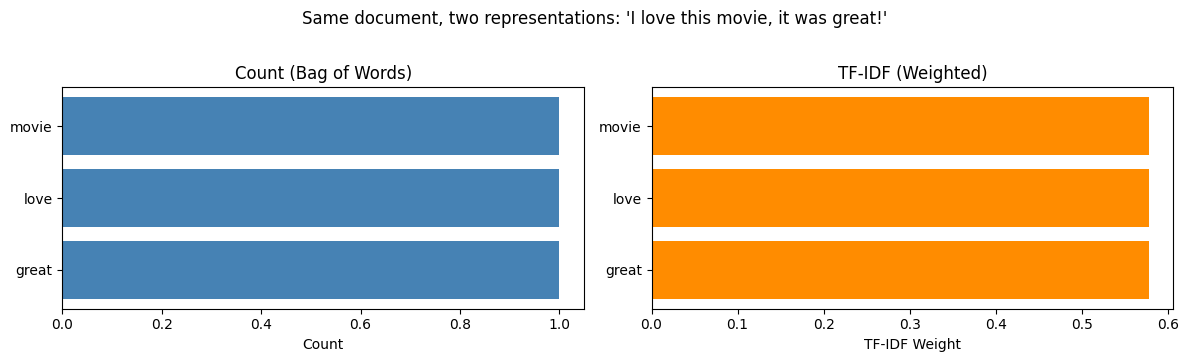

Counts are flat — every word looks equally important.
TF-IDF differentiates: words unique to this document get higher weight.


In [ ]:
#| eval: false

# Visual comparison for one document
doc_idx = 0
tokens = sorted(count_entries.keys())
counts_vals = [count_entries[t] for t in tokens]
tfidf_vals = [tfidf_entries.get(t, 0) for t in tokens]

fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))

axes[0].barh(tokens, counts_vals, color="steelblue")
axes[0].set_title("Count (Bag of Words)")
axes[0].set_xlabel("Count")

axes[1].barh(tokens, tfidf_vals, color="darkorange")
axes[1].set_title("TF-IDF (Weighted)")
axes[1].set_xlabel("TF-IDF Weight")

fig.suptitle(f"Same document, two representations: '{corpus[doc_idx]}'", y=1.02)
plt.tight_layout()
plt.show()

print("Counts are flat — every word looks equally important.")
print("TF-IDF differentiates: words unique to this document get higher weight.")

This approach tries to show that some words are more "informative" than others based on how rare they are in the entire collection.

In a larger corpus, a common word like "movie" would receive a lower weight because it likely appears in almost every review.

This visualization is trying to demonstrate that while the counts are "flat" (everyone gets a 1), TF-IDF differentiates the values. Even if the bars look similar in this small example, the TF-IDF values are actually calculated weights (around 0.5774 in this case) rather than simple counts. TF-IDF moves us away from just counting to "ranking" words by their importance to the text.

### Exercise 3

Why might the word "great"receive a higher weight in a large corpus than the word "movie"?

In [ ]:
q3_answer = ""

## Step 4: VADER — A Dense Alternative

Not all text representations are sparse. **VADER** (Valence Aware Dictionary and sEntiment Reasoner) is rule-based:

- A hand-crafted dictionary assigns sentiment scores to ~7,500 words
- Rules handle negation ("not good"), intensifiers ("very"), capitalization, punctuation
- Output: exactly **4 numbers** — negative, neutral, positive, compound

This is a **dense** representation: no zeros, and always 4 dimensions regardless of vocabulary size. Extreme compression — but almost all word-level information is lost.

In [ ]:
#| eval: false

sid = SentimentIntensityAnalyzer()

def vader_scores(text):
    """Return VADER sentiment scores as a dict."""
    return sid.polarity_scores(text)

print("VADER: any text → 4 numbers\n")
for text in corpus[:4]:
    scores = vader_scores(text)
    print(f"  '{text}'")
    print(f"   → neg={scores['neg']:.3f}  neu={scores['neu']:.3f}  "
          f"pos={scores['pos']:.3f}  compound={scores['compound']:+.4f}\n")

VADER: any text → 4 numbers

  'I love this movie, it was great!'
   → neg=0.000  neu=0.368  pos=0.632  compound=+0.8622

  'terrible film, absolutely horrible'
   → neg=0.775  neu=0.225  pos=0.000  compound=-0.7841

  'the acting was excellent and moving'
   → neg=0.000  neu=0.575  pos=0.425  compound=+0.5719

  'I hated every minute of it'
   → neg=0.457  neu=0.543  pos=0.000  compound=-0.6369



In [ ]:
#| eval: false

# The dimensionality gap
print("Dimensions per representation:\n")
print(f"  Count vector:  {X_counts.shape[1]:>4} dims  (one per vocabulary word)")
print(f"  TF-IDF vector: {X_tfidf.shape[1]:>4} dims  (same vocabulary)")
print(f"  VADER:            4 dims  (fixed: neg, neu, pos, compound)")
print(f"\nFor a real corpus with 50,000 unique words:")
print(f"  Sparse vectors: 50,000 dims (but >99% zeros → efficient storage)")
print(f"  VADER: still 4 dims (massive compression, massive information loss)")

Dimensions per representation:

  Count vector:    30 dims  (one per vocabulary word)
  TF-IDF vector:   30 dims  (same vocabulary)
  VADER:            4 dims  (fixed: neg, neu, pos, compound)

For a real corpus with 50,000 unique words:
  Sparse vectors: 50,000 dims (but >99% zeros → efficient storage)
  VADER: still 4 dims (massive compression, massive information loss)


### Exercise 4:

Make up a tricky sentence and use vader_scores() to score it. What sentence can you write that gives you a bad answer? Do you find VADER works fairly well or not?

In [ ]:
q4_answer = ""

## Step 5: Naive Bayes on Count Vectors

Now we train classifiers and examine what they learn. **Multinomial Naive Bayes** takes count vectors as input and estimates:

> For each class (positive / negative), how likely is each word to appear?

It builds a probability table P(word | class) for every word in the vocabulary. This is **dense** internally — every word gets a non-zero probability thanks to Laplace smoothing. Even words the model has never seen in a given class still get a small probability.

The input is sparse (count vectors), but the learned representation is dense.

In [ ]:
#| eval: false

nb_model = MultinomialNB()
nb_model.fit(X_counts, labels)

# Learned word probabilities per class
nb_probs_pos = np.exp(nb_model.feature_log_prob_[1])  # P(word | positive)
nb_probs_neg = np.exp(nb_model.feature_log_prob_[0])  # P(word | negative)

nb_df = pd.DataFrame({
    "word": vocab,
    "P(w|pos)": np.round(nb_probs_pos, 4),
    "P(w|neg)": np.round(nb_probs_neg, 4),
})
nb_df["pos/neg ratio"] = np.round(nb_df["P(w|pos)"] / nb_df["P(w|neg)"], 2)
nb_df = nb_df.sort_values("pos/neg ratio", ascending=False)

print("Naive Bayes: learned P(word | class)\n")
print(nb_df.to_string(index=False))
print(f"\nEvery word has a non-zero probability — the learned representation is dense.")
print(f"Words with high pos/neg ratio are the strongest positive indicators.")

Naive Bayes: learned P(word | class)

         word  P(w|pos)  P(w|neg)  pos/neg ratio
    wonderful    0.0426    0.0227           1.88
        movie    0.0426    0.0227           1.88
  performance    0.0426    0.0227           1.88
         love    0.0426    0.0227           1.88
        heart    0.0426    0.0227           1.88
       acting    0.0426    0.0227           1.88
        great    0.0426    0.0227           1.88
        start    0.0426    0.0227           1.88
       finish    0.0426    0.0227           1.88
        story    0.0426    0.0227           1.88
   experience    0.0426    0.0227           1.88
    excellent    0.0426    0.0227           1.88
       entire    0.0426    0.0227           1.88
         cast    0.0426    0.0227           1.88
    brilliant    0.0426    0.0227           1.88
      amazing    0.0426    0.0227           1.88
         move    0.0426    0.0227           1.88
     terrible    0.0213    0.0455           0.47
         time    0.0213    0.04

In [ ]:
#| eval: false

def predict_sentiment(text):
    """Classify a sentence as positive or negative using the trained NB model."""
    vec = count_vec.transform([text])
    label = nb_model.predict(vec)[0]
    proba = nb_model.predict_proba(vec)[0]
    
    return {
        "text": text,
        "sentiment": "positive" if label == 1 else "negative",
        "confidence": proba[label],
        "P(positive)": round(proba[1], 3),
        "P(negative)": round(proba[0], 3),
    }

In [ ]:
#| eval: false

# Try it
for s in ["I love this movie", "terrible and boring", "it was okay"]:
    result = predict_sentiment(s)
    print(f"{result['sentiment']:>8} ({result['confidence']:.1%})  '{s}'")

positive (77.8%)  'I love this movie'
negative (82.0%)  'terrible and boring'
negative (50.0%)  'it was okay'


### Exercise 5

Looking at nb_df, note how consistent the probabilities are for the words in this corpus. Why is this? What is the model doing?

In [ ]:
q5_answer = ""

## Step 6: Logistic Regression on TF-IDF — Learned Sparsity

**Logistic Regression** learns a **weight (coefficient)** for each feature. Positive weights push the prediction toward positive, negative weights toward negative.

With **L1 regularization** ("Lasso"), the model is penalized for having many non-zero weights. This forces unimportant weights to *exactly* zero — the model discovers which words matter and ignores the rest.

Here is a short tutorial on Lasso regularization. https://thaddeus-segura.com/lasso-ridge/. Read through it, so that you understand what Lasso (L1) does.

Logistic regression is demonstrating different kind of sparsity than from the examples above:

- **Input sparsity** (count/TF-IDF): most documents don't contain most words → structural zeros
- **Learned sparsity** (L1): the model decides most words aren't useful → learned zeros

Contrast with Naive Bayes, where every word always gets a non-zero probability.

For this toy corpus, we have only 10 samples. We will demonstrate a logistic regression model by using hand weights, instead of tuning a model via cross-validation. 

The goal is a demonstration of the sparcity concept when **coefficients appear and disappear** as we adjust two hyperparameters:

- The **L1 hyperparameter** will determine which words matter the most and **force other weights to zero**. It will zero out some of the features (words) to zero so that they contribute nothing to the prediction (vs L2 shrinking coefficients).
- The **C hyperparameter** is like a volume control that lets you tune penalty. Ordinarily, you wouldn't touch this hyperparameter and instead do cross-validation.
    - Small C - heavy bias towards L1 with zero coefficients
    - Big C - heavy bias away from L1 and bias towards non-zero coefficients

In [ ]:
#| eval: false

lr_model = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    C=10.0,              # regularization strength (smaller C = more sparsity)
    random_state=42
)
lr_model.fit(X_tfidf, labels)

lr_coefs = lr_model.coef_[0]

lr_df = pd.DataFrame({
    "word": vocab,
    "coefficient": np.round(lr_coefs, 4)
}).sort_values("coefficient", key=abs, ascending=False)

print("Logistic Regression: learned weight per vocabulary word\n")
print(lr_df.to_string(index=False))

n_zero = int(np.sum(np.abs(lr_coefs) < 1e-6))
n_total = len(lr_coefs)
print(f"\n{n_zero} of {n_total} coefficients are exactly zero.")
print(f"L1 regularization learned that only {n_total - n_zero} words matter.")

Logistic Regression: learned weight per vocabulary word

         word  coefficient
        awful      -3.7018
       minute      -3.5087
        waste      -3.2676
     terrible      -3.1018
disappointing      -3.0661
         good      -1.6122
   absolutely      -1.2166
          hat      -1.1696
       boring      -1.1355
     horrible      -0.7674
  predictable      -0.7654
         film      -0.6958
         time      -0.6131
    brilliant       0.1014
        great       0.1014
         move       0.1014
        movie       0.0000
      amazing       0.0000
        story       0.0000
        start       0.0000
  performance       0.0000
       entire       0.0000
    excellent       0.0000
         love       0.0000
        heart       0.0000
       acting       0.0000
         cast       0.0000
       finish       0.0000
   experience       0.0000
    wonderful       0.0000

14 of 30 coefficients are exactly zero.
L1 regularization learned that only 16 words matter.


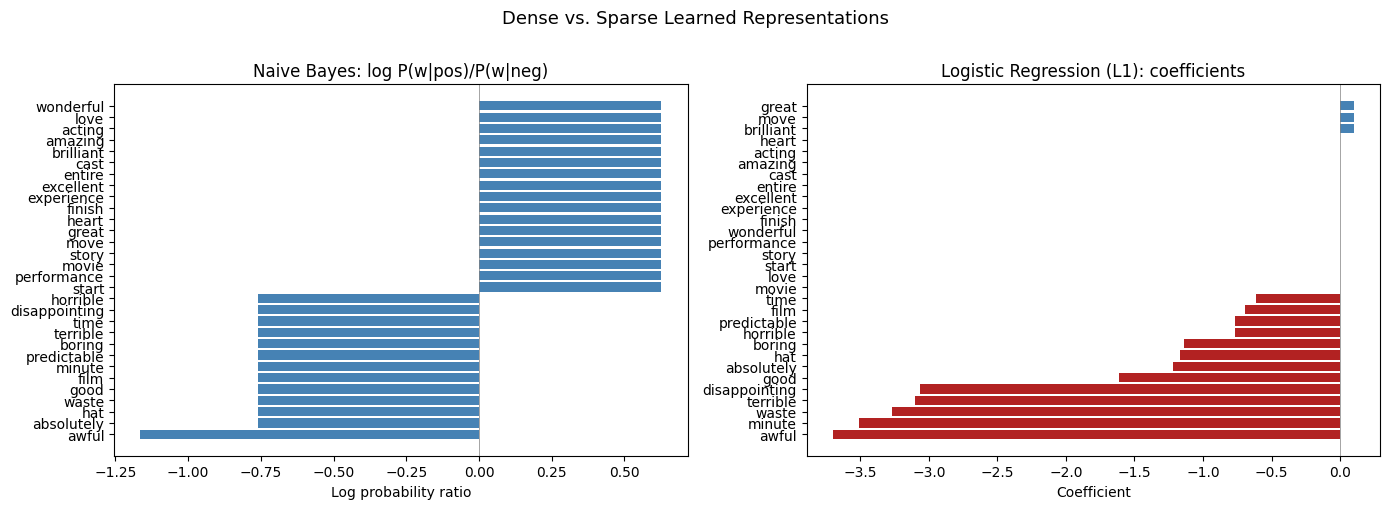

Left (NB): every word has a non-zero value — dense learned representation.
Right (LR+L1): When gray bars are exactly zero — the model learned to ignore those words.


In [ ]:
#| eval: false

# Compare learned representations: NB (dense) vs LR (sparse)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# NB: log odds ratio
nb_log_ratio = np.log(nb_probs_pos / nb_probs_neg)
sorted_idx_nb = np.argsort(nb_log_ratio)
axes[0].barh(vocab[sorted_idx_nb], nb_log_ratio[sorted_idx_nb], color="steelblue")
axes[0].set_title("Naive Bayes: log P(w|pos)/P(w|neg)")
axes[0].set_xlabel("Log probability ratio")
axes[0].axvline(x=0, color="gray", linewidth=0.5)

# LR: coefficients (many are zero with L1)
sorted_idx_lr = np.argsort(lr_coefs)
colors = ["firebrick" if c < 0 else "steelblue" if c > 0 else "lightgray"
          for c in lr_coefs[sorted_idx_lr]]
axes[1].barh(vocab[sorted_idx_lr], lr_coefs[sorted_idx_lr], color=colors)
axes[1].set_title("Logistic Regression (L1): coefficients")
axes[1].set_xlabel("Coefficient")
axes[1].axvline(x=0, color="gray", linewidth=0.5)

fig.suptitle("Dense vs. Sparse Learned Representations", fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

print("Left (NB): every word has a non-zero value — dense learned representation.")
print("Right (LR+L1): When gray bars are exactly zero — the model learned to ignore those words.")

In [ ]:
#| eval: false

import eli5

doc = "I love this movie, it was great"
eli5.show_prediction(lr_model, doc, vec=tfidf_vec)

The ELI5 (Explain Like I'm 5) output is helpful to see how the Logistic Regression model reached its decision for the sentence: "I love this movie, it was great."

Here is how to interpret it.

Prediction Summary:
- **y=1**: This indicates the model predicted the "positive" class (where 1 = positive and 0 = negative).
- **Probability 0.827**: The model is 82.7% confident that this review is positive.
- **Score 1.563**: This is the raw output (logit) before it is converted into a probability. A positive score leads to a "positive" prediction.

Top Features Table:
- <BIAS> (+1.505): This is the model's "starting point" or intercept. Even without looking at any specific words, the model has a baseline bias toward the positive class because this sentence was labeled positive.
- great (+0.059): ELI5 identified "great" as a feature that contributed positively to the score.
- Missing Words: Notice that "love" and "movie" are not listed. This is because the L1 regularization (seen in earlier cells) forced those specific coefficients to exactly zero, meaning the model learned to ignore them entirely when making a prediction.

In short, ELI5 shows that for this model, the word "great" was the only active evidence in the text pushing the prediction toward "positive," supplemented by a strong baseline bias.

## Exercise 6: Which Word Survives First?

At C=0.01, L1 regularization zeros out every coefficient — the model predicts using only its intercept. As you increase C, you loosen the penalty, allowing the model to "spend" on coefficients that improve predictions.

But words don't all earn a coefficient at the same threshold. The model decides: **which word is worth its L1 cost first?**

Before running the code below, write down your predictions. Use the graphs above (from the original configuration with L1 and C=10.0) to help inform your answer. Then try commenting out both C and L1, separately.

1. **Which word will get a non-zero coefficient first?** Look back at the corpus and the count matrix. What makes a word "worth it" — frequency? appearing in only one class? something else?

2. **Will it be a positive word or a negative word?** Think about what the intercept can do for free (without any coefficients), and what it *can't* do alone.

3. **What will happen to the intercept as coefficients start appearing?** Will it stay near zero, go positive, or go negative?

In [ ]:
#| eval: false

# Sweep C from small to large — watch which words emerge and when
import warnings
warnings.filterwarnings("ignore")

c_values = [0.01, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 10.0, 15.0]
prev_active = set()

print(f"{'C':>5}  {'#nz':>4}  {'intercept':>10}  newly appeared")
print("-" * 70)

for C in c_values:
    m = LogisticRegression(penalty="l1", solver="liblinear", C=C, random_state=42)
    m.fit(X_tfidf, labels)

    coefs = m.coef_[0]
    active = {vocab[i] for i in range(len(coefs)) if abs(coefs[i]) > 1e-6}
    new = active - prev_active
    n_nz = len(active)

    if new:
        details = ", ".join(
            f"{w} ({coefs[list(vocab).index(w)]:+.3f})"
            for w in sorted(new, key=lambda w: coefs[list(vocab).index(w)])
        )
    else:
        details = "—"

    print(f"{C:>5.02f}  {n_nz:>4}  {m.intercept_[0]:>+10.4f}  {details}")
    prev_active = active

    C   #nz   intercept  newly appeared
----------------------------------------------------------------------
 0.01     0     +0.0000  —
 0.50     0     +0.0000  —
 1.00     0     +0.0000  —
 2.00     0     +0.0000  —
 3.00     4     +0.0000  awful (-0.693), disappointing (-0.162), minute (-0.162), hat (-0.000)
 4.00    16     +0.1843  predictable (-0.278), good (-0.192), terrible (-0.178), film (-0.105), absolutely (-0.083), time (-0.036), boring (-0.035), waste (-0.020), horrible (-0.002), move (+0.148), brilliant (+0.148), great (+0.148)
 5.00    16     +0.5612  —
 6.00    16     +0.8342  —
 7.00    16     +1.0485  —
 8.00    16     +1.2248  —
10.00    16     +1.5045  —
15.00    16     +1.9816  —


### Regularization controls sparsity

The `C` parameter in Logistic Regression controls how aggressively L1 pushes weights to zero. Smaller C = stronger regularization = more zeros = sparser model.

In [ ]:
#| eval: false

# How C affects sparsity
print(f"{'C':>8}  {'Non-zero coefficients':>22}  {'Zero coefficients':>18}")
print("-" * 52)

for C in [0.01, 0.1, 1.0, 10.0, 100.0]:
    lr_temp = LogisticRegression(
        penalty="l1", solver="liblinear", C=C, random_state=42
    )
    lr_temp.fit(X_tfidf, labels)
    n_nz = int(np.sum(np.abs(lr_temp.coef_[0]) > 1e-6))
    n_z = len(lr_temp.coef_[0]) - n_nz
    print(f"{C:>8.2f}  {n_nz:>22}  {n_z:>18}")

print("\nSmaller C → stronger penalty → more weights forced to zero → sparser model.")
print("Larger C → weaker penalty → model is free to use all features.")

       C   Non-zero coefficients   Zero coefficients
----------------------------------------------------
    0.01                       0                  30
    0.10                       0                  30
    1.00                       0                  30
   10.00                      16                  14
  100.00                      16                  14

Smaller C → stronger penalty → more weights forced to zero → sparser model.
Larger C → weaker penalty → model is free to use all features.


### What do you observe?

- **Which word(s) appeared first?** Was your prediction correct?
- **Were they positive or negative words?** Why does that make sense given how the intercept works? (Hint: The intercept is where the prediction sees no useful words. The intercept is "free" — L1 doesn't penalize it.)
- **How did the intercept change** as the first coefficients appeared? Why did it shift in that direction?


### Exercise
What do you need to do to make all coefficients 0 in the lr_model above?

In [ ]:
q6_answer = ""

## Putting It All Together

Let's trace new sentences through every representation to see how the same text looks under each approach.

In [ ]:
#| eval: false

def compare_representations(sentence):
    """Show all representations for a sentence, side by side."""
    print(f"Input: '{sentence}'")
    print("=" * 70)

    # 1. Tokenization
    tokens = tokenize(sentence)
    print(f"\n1. Tokens: {tokens}")
    print(f"   {len(sentence)} characters → {len(tokens)} tokens")

    # 2. Count vector
    vec_count = count_vec.transform([sentence])
    print(f"\n2. Count Vector (Bag of Words):")
    show_sparse_vector(vec_count, vocab)

    # 3. TF-IDF vector
    vec_tfidf = tfidf_vec.transform([sentence])
    print(f"\n3. TF-IDF Vector (Weighted):")
    show_sparse_vector(vec_tfidf, vocab)

    # 4. VADER
    scores = vader_scores(sentence)
    print(f"\n4. VADER (Dense, 4-dim):")
    print(f"  neg={scores['neg']:.3f}  neu={scores['neu']:.3f}  "
          f"pos={scores['pos']:.3f}  compound={scores['compound']:+.4f}")

    # 5. Model predictions
    nb_prob = nb_model.predict_proba(vec_count)[0][1]
    lr_prob = lr_model.predict_proba(vec_tfidf)[0][1]
    print(f"\n5. Predictions:")
    print(f"   Naive Bayes P(positive):        {nb_prob:.3f}")
    print(f"   Logistic Regression P(positive): {lr_prob:.3f}")
    print(f"   VADER compound:                  {scores['compound']:+.4f}")
    print()

In [ ]:
#| eval: false

test_sentences = [
    "This movie was great but the ending was horrible",
    "An excellent and moving performance",
    "It was okay, nothing special",
    "Absolutely terrible waste of time",
]

for sentence in test_sentences:
    compare_representations(sentence)
    print()

Input: 'This movie was great but the ending was horrible'

1. Tokens: ['movie', 'great', 'ending', 'horrible']
   48 characters → 4 tokens

2. Count Vector (Bag of Words):
  Dimensions: 30 total, 3 non-zero (3/30)
  Non-zero:   {'great': 1.0, 'horrible': 1.0, 'movie': 1.0}

3. TF-IDF Vector (Weighted):
  Dimensions: 30 total, 3 non-zero (3/30)
  Non-zero:   {'great': 0.5774, 'horrible': 0.5774, 'movie': 0.5774}

4. VADER (Dense, 4-dim):
  neg=0.332  neu=0.490  pos=0.178  compound=-0.4939

5. Predictions:
   Naive Bayes P(positive):        0.621
   Logistic Regression P(positive): 0.754
   VADER compound:                  -0.4939


Input: 'An excellent and moving performance'

1. Tokens: ['excellent', 'move', 'performance']
   35 characters → 3 tokens

2. Count Vector (Bag of Words):
  Dimensions: 30 total, 3 non-zero (3/30)
  Non-zero:   {'excellent': 1.0, 'move': 1.0, 'performance': 1.0}

3. TF-IDF Vector (Weighted):
  Dimensions: 30 total, 3 non-zero (3/30)
  Non-zero:   {'excellent'

### What happens with unknown words?

When a word wasn't in the training corpus, count and TF-IDF vectorizers simply ignore it — it doesn't have a column in the vocabulary. VADER can still score it if it's in VADER's dictionary. This is a fundamental limitation of vocabulary-based sparse representations.

In [ ]:
#| eval: false

# A sentence with many out-of-vocabulary words
oov_sentence = "The cinematography was breathtaking and sublime"
compare_representations(oov_sentence)
print("Note: words not in the training vocabulary disappear from count/TF-IDF vectors.")
print("VADER can still score them if they're in its own dictionary.")

Input: 'The cinematography was breathtaking and sublime'

1. Tokens: ['cinematography', 'breathtake', 'sublime']
   47 characters → 3 tokens

2. Count Vector (Bag of Words):
  Dimensions: 30 total, 0 non-zero (0/30)
  Non-zero:   {}

3. TF-IDF Vector (Weighted):
  Dimensions: 30 total, 0 non-zero (0/30)
  Non-zero:   {}

4. VADER (Dense, 4-dim):
  neg=0.000  neu=0.625  pos=0.375  compound=+0.4588

5. Predictions:
   Naive Bayes P(positive):        0.500
   Logistic Regression P(positive): 0.818
   VADER compound:                  +0.4588

Note: words not in the training vocabulary disappear from count/TF-IDF vectors.
VADER can still score them if they're in its own dictionary.


### Exercise 7

What is the term used when a word is unknown?

In [ ]:
q7_answer = ""

## Key Takeaways

**What is a sparse vector?** A vector where most entries are zero. For text, this arises naturally because any single document uses a tiny fraction of the total vocabulary.

**Why sparsity = compression.** A document with 20 unique words in a 10,000-word vocabulary needs to store only ~20 values, not 10,000. Scipy's CSR format exploits this by recording only (position, value) pairs for non-zero entries.

**What gets lost?** Bag-of-words representations discard word order — "dog bites man" and "man bites dog" produce identical vectors. They also lose syntax, context, and nuance. Only word identity and frequency survive.

**Count vs. TF-IDF.** Same sparsity structure (same zeros), different values. TF-IDF downweights words that appear everywhere and upweights distinctive words — a better signal for classifiers.

**Dense vs. sparse.** VADER compresses any text into 4 numbers — extreme compression, no vocabulary dependence, but nearly all word-level detail is gone. Count/TF-IDF vectors are high-dimensional but sparse and preserve word-level information.

**Learned sparsity.** L1 regularization lets Logistic Regression discover which features don't matter and zero them out. This is compression learned from data, not just a structural property of the input. Naive Bayes, by contrast, always produces dense parameter estimates.

**Beyond sparse vectors.** Dense embeddings (Word2Vec, GloVe, BERT) -- which we will explore in a couple of weeks -- address many limitations of sparse representations by learning compact, dense vectors where semantically similar words land near each other. But sparse vectors remain valuable as interpretable, efficient baselines — and the concepts of compression, dimensionality, and sparsity transfer directly to understanding those richer representations.

In [ ]:
q8_answer = "What did you find most interesting about this lab"

In [ ]:
q9_answer = "what did you find that was surprising?"

In [ ]:
#| eval: false

# REVIEW ONLY — does not submit

from data401_nlp.helpers.submit import collect_answers, parse_answers, submit_answers
from data401_nlp.helpers.env import load_env
load_env()

# REVIEW ONLY — does not submit

raw = collect_answers(
    show=True,
    namespace=globals(),   
)

answers = parse_answers(raw)

print(f"\nDetected {len(answers)} answers:")
for k in answers:
    print(" ", k)

In [ ]:
#| eval: false

ALLOW_SUBMISSION = False   # ← student MUST change this

def submit_for_credit(student_id):
    if not ALLOW_SUBMISSION:
        raise RuntimeError(
            "⚠️ Submission is disabled.\n\n"
            "To submit:\n"
            "  1. Set ALLOW_SUBMISSION = True\n"
            "  2. Re-run this cell"
        )

    submit_answers(
        student_id=student_id,
        answers=answers,   # uses reviewed answers
    )

    print("✅ Submission complete.")

In [ ]:
#| eval: false

submit_answers("your name", answers=answers)